# Problem Statement
The aim of this Project is to predict the taxi fare of NYC given information about the pickup and drop off locations, the pickup date time and number of passengers travelling.

## File descriptions
__train.csv__ - Input features and target fare_amount values for the training set (about 55M rows). <br>
__test.csv__ - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.


### Features
1. __pickup_datetime__ - timestamp value indicating when the taxi ride started.
2. __pickup_longitude__ - float for longitude coordinate of where the taxi ride started.
3. __pickup_latitude__ - float for latitude coordinate of where the taxi ride started.
4. __dropoff_longitude__ - float for longitude coordinate of where the taxi ride ended.
5. __dropoff_latitude__ - float for latitude coordinate of where the taxi ride ended.
6. __passenger_count__ - integer indicating the number of passengers in the taxi ride.

### Target
__fare_amount__ - float dollar amount of the cost of the taxi ride. 

## Disclaimer
Some ideas/thoughts has been taken from kernels of kaggle competition. Just for learning point of view.

In [351]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

#Seaborn is a library for making statistical graphics in Python.
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from datetime import timedelta
import datetime as dt
from datetime import datetime
import calendar

from collections import Counter

This dataset has 55 Million rows which is huge and requires a lot of memory. So, we had read only a small set of rows to explor the data. Generally, performance of a machine learning model increases as the amount of training data increases. However, there might be diminishing returns, and we sample the data here in order to train faster. The data file is randomly sorted by date, so taking the first 6 million rows is a random sample in terms of time.

In [352]:
train =  pd.read_csv('train.csv',sep =',', nrows = 6000000)

In [353]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [354]:
train.shape

(6000000, 8)

In [355]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 366.2+ MB


In [356]:
# Summary statistics
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,6.000000e+06,6.000000e+06,6.000000e+06,5.999961e+06,5.999961e+06,6.000000e+06
mean,1.134049e+01,-7.251142e+01,3.992406e+01,-7.251060e+01,3.992049e+01,1.684645e+00
std,9.810989e+00,1.280236e+01,9.022813e+00,1.285400e+01,9.367604e+00,1.327794e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.345917e+03,2.080000e+02


### Thought Process

- __Trip distance__ : If the distance is traveled more, then fare should be higher.
- __Time of Travel__ : During heavy traffic, the taxi fare may be higher.
- __Fare diff btw day and night__: Fare at night is different from day time.
- __Day of Travel__ : Fare amount may differ on weekday and weekends
- __Is it a trip to/from airport__ : Trips to/from airport generally have a fixed fare.
- __Pickup or Drop-off Region__ : Fare may be different based on the kind of location/region.
- __Availability of taxi__ : If a particular location has a lot of cabs available, the fares may be lower.

***

### Check Missing values

In [357]:
train.isnull().sum().sum()

78

From the summary statistics, we find that there are total 39 tuples which have missing values out of 6 Million rows.

In [358]:
print('Old size: %d' % len(train))
train = train.dropna(how = 'any', axis = 'rows')  
print('New size: %d' % len(train))

Old size: 6000000
New size: 5999961


***

### Let's analyse fare amount

In [359]:
train.fare_amount.describe()

count    5.999961e+06
mean     1.134044e+01
std      9.810895e+00
min     -1.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

Here, we observed that some tuples have negative fare. Lets see how many of them are negative ?

C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Trip Fare')

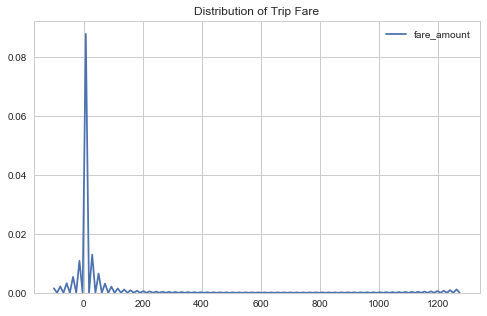

In [360]:
plt.figure(figsize=(8,5))
sns.kdeplot(train['fare_amount']).set_title("Distribution of Trip Fare")

There are some negative fare amount in the data and also it is skewed. Let us have a look at these data points

In [361]:
from collections import Counter
Counter(train['fare_amount']<0)

Counter({False: 5999699, True: 262})

Since, the cost of a trip cannot be negative we removed such instances from the data.

In [362]:
print('Old size: %d' % len(train))
train = train[(train['fare_amount'] > 0) & (train['fare_amount'] <= 200)]
print('New size: %d' % len(train))

Old size: 5999961
New size: 5999346


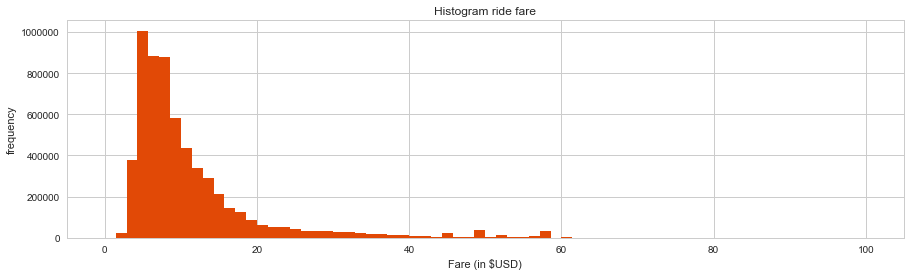

In [363]:
train[train.fare_amount<100].fare_amount.hist(bins=70, figsize=(15,4), color='#E14906') #because values for fare>60 are very less
plt.xlabel('Fare (in $USD)')
plt.ylabel('frequency')
plt.title('Histogram ride fare')
plt.savefig('fare')

we can clearly see that the fare amount follows a long tail distribution.To understand the distribution of fare amount better we take a log transformation after removing the negative fares- this makes the distribution close to normal distribution(i.e symmetric distribution).

C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of fare amount (log scale)')

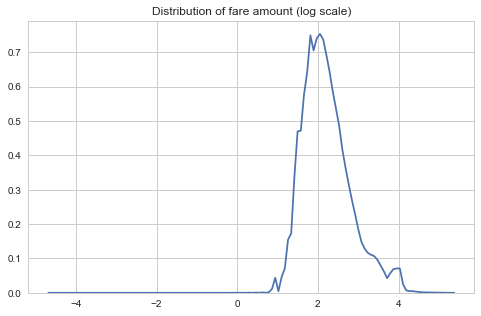

In [364]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

***

### Let's analyse passenger_count

In [365]:
train.passenger_count.describe()

count    5.999346e+06
mean     1.684668e+00
std      1.327808e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64

We observed that in some of the trips, the number of passenger traveling in the taxi is greater than the taxi capacity and in some trips no passenger is traveling(this part we analyze later). let's see how many are ?

In [366]:
from collections import Counter
Counter(train['passenger_count']>6)

Counter({False: 5999334, True: 12})

In [367]:
print('Old size: %d' % len(train))
train = train[(train['passenger_count'] >= 0) & (train['passenger_count'] <= 6)]
print('New size: %d' % len(train))

Old size: 5999346
New size: 5999334


In [368]:
train['passenger_count'].value_counts()

1    4150122
2     886060
5     424676
3     263184
4     127322
6     126797
0      21173
Name: passenger_count, dtype: int64

***

### Let's analyse location

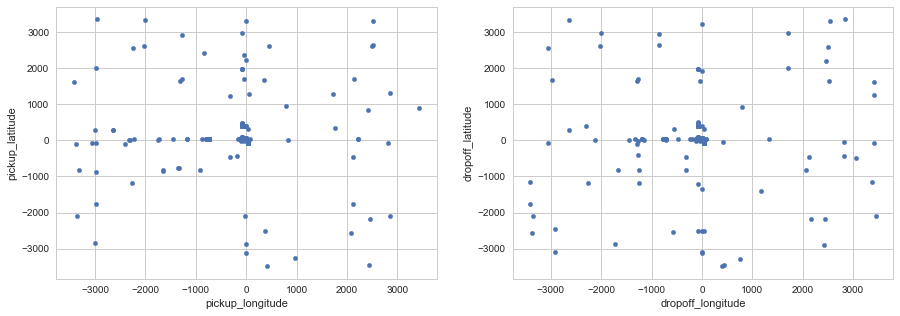

In [369]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns
#train.iloc[:1000].plot.scatter('pickup_longitude', 'pickup_latitude',ax=ax1)
#train.iloc[:1000].plot.scatter('dropoff_longitude', 'dropoff_latitude',ax=ax2) 

train.plot.scatter('pickup_longitude', 'pickup_latitude',ax=ax1)
train.plot.scatter('dropoff_longitude', 'dropoff_latitude',ax=ax2) 

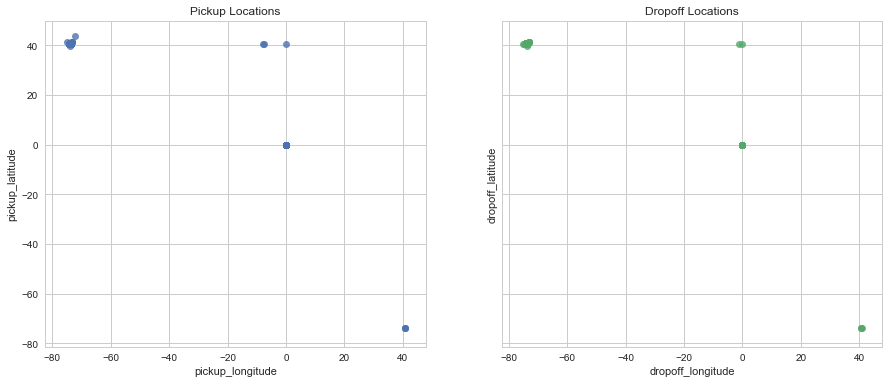

In [370]:
# Set random seed 
RSEED = 100


fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharex=True, sharey=True)
axes = axes.flatten()

sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = train.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = train.sample(10000, random_state = RSEED), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

***

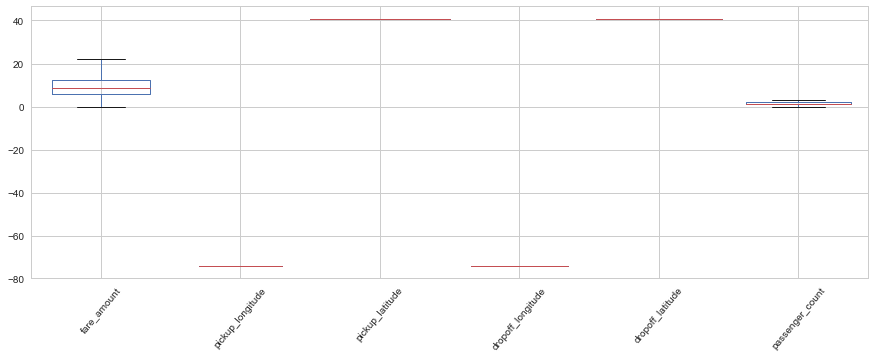

In [371]:
train.boxplot(rot=50, fontsize=10, showfliers=False, widths=(0.7, 0.6, 1, 0.7, 0.9, 0.75),figsize = (15,5))
plt.savefig("boxplot")

***

# 1) Data Cleaning

- remove __NULL__ records in the rows
- remove records whose locations are not within range provided in test data
- remove outlier according to fare distribution

In [372]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.999334e+06,5.999334e+06,5.999334e+06,5.999334e+06,5.999334e+06,5.999334e+06
mean,1.133333e+01,-7.251213e+01,3.992445e+01,-7.251124e+01,3.992102e+01,1.684394e+00
std,9.678800e+00,1.280066e+01,9.022265e+00,1.282567e+01,9.366799e+00,1.307777e+00
min,1.000000e-02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,2.000000e+02,3.439426e+03,3.344459e+03,3.457622e+03,3.345917e+03,6.000000e+00


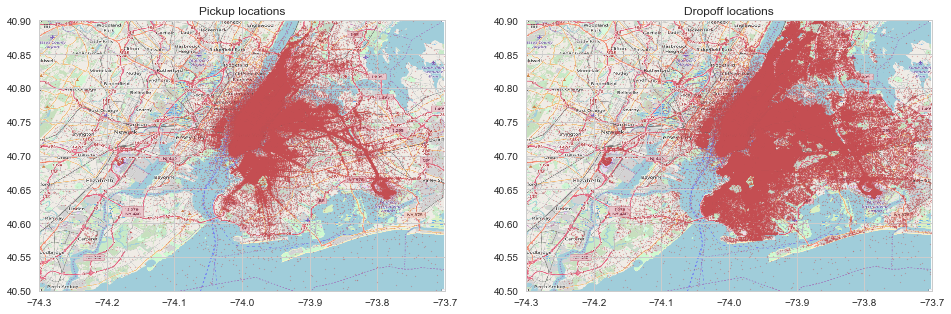

In [373]:
# plot training data on map zoomed in
plot_on_map(train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

### Select a rectangular region

In [374]:
test = pd.read_csv('test.csv')

In [375]:
# range of longitude
min(test.pickup_longitude.min(), test.dropoff_longitude.min()), \
max(test.pickup_longitude.max(), test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [376]:
# range of latitude
min(test.pickup_latitude.min(), test.dropoff_latitude.min()), \
max(test.pickup_latitude.max(), test.dropoff_latitude.max())

(40.568973, 41.709555)

In [377]:
# Define area for NYC city
area = [-74.2, -72.8, 40.6, 41.7]

In [378]:
def select_bdry(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [379]:
print('Old size: %d' % len(train))
train = train[select_bdry(train, area)]
print('New size: %d' % len(train))

Old size: 5999334
New size: 5865998


In [380]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

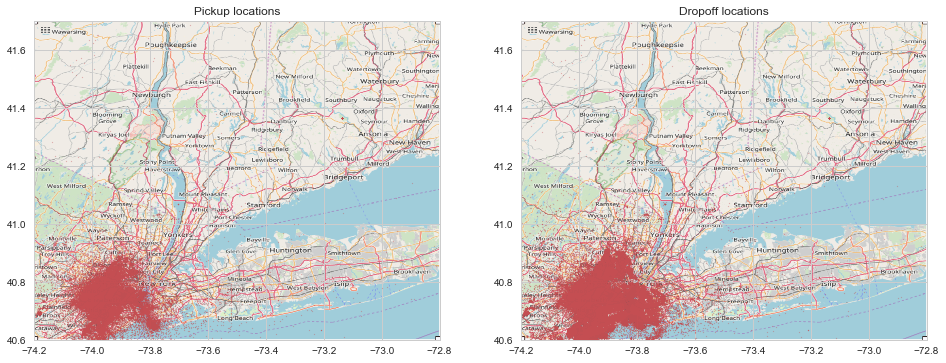

In [381]:
# plot training data on map
plot_on_map(train, area, nyc_map, s=1, alpha=0.3)

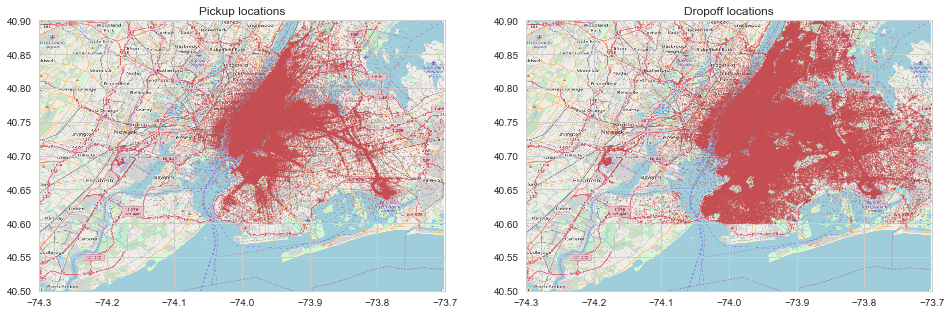

In [382]:
# plot training data on map zoomed in
plot_on_map(train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

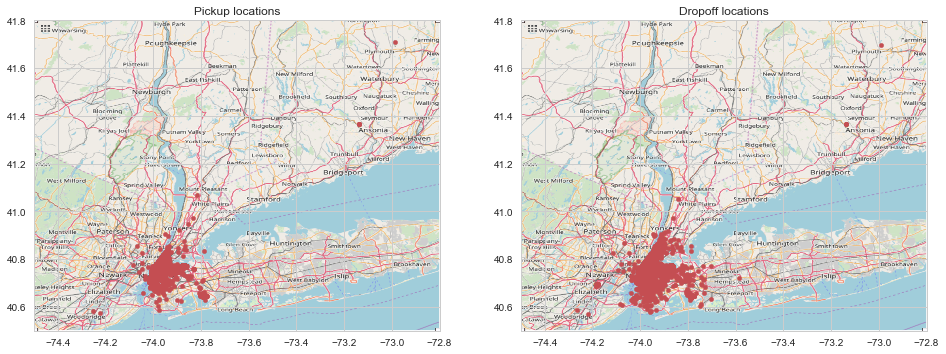

In [383]:
plot_on_map(test, BB, nyc_map, alpha=1.0, s=20)

From the scatter plot of training data, we see that some locations are in the water.

***

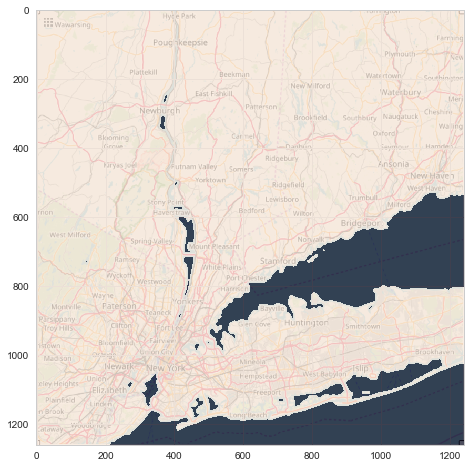

In [384]:
#lets analyse the points in the water

nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in white, False in black.

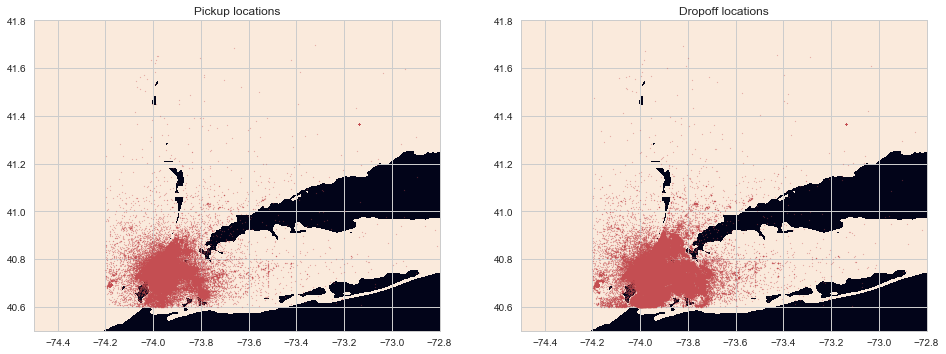

In [385]:
plot_on_map(train, BB, nyc_mask, s=1, alpha=0.3)

In [386]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

pickup_x, pickup_y = lonlat_to_xy(train.pickup_longitude, train.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(train.dropoff_longitude, train.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [387]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 801


### Remove points which are on the water

In [388]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define rectangular region
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [389]:
print('Old size: %d' % len(train))
train = remove_datapoints_from_water(train)
print('New size: %d' % len(train))

Old size: 5865998
New size: 5865197


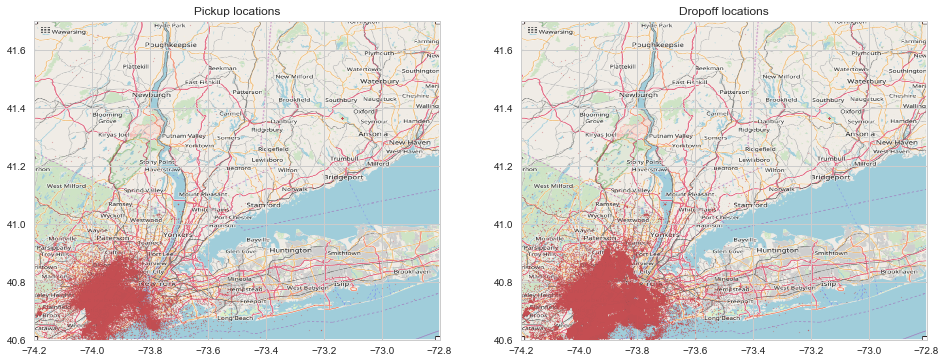

In [390]:
plot_on_map(train, area, nyc_map, s=1, alpha=0.3)

***

In [391]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.865197e+06,5.865197e+06,5.865197e+06,5.865197e+06,5.865197e+06,5.865197e+06
mean,1.128487e+01,-7.397516e+01,4.075115e+01,-7.397426e+01,4.075160e+01,1.684367e+00
std,9.512906e+00,3.803793e-02,2.931206e-02,3.711122e-02,3.228364e-02,1.307481e+00
min,1.000000e-02,-7.419993e+01,4.060000e+01,-7.419981e+01,4.060000e+01,0.000000e+00
25%,6.000000e+00,-7.399227e+01,4.073660e+01,-7.399157e+01,4.073570e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075337e+01,-7.398061e+01,4.075391e+01,1.000000e+00
75%,1.250000e+01,-7.396834e+01,4.076755e+01,-7.396538e+01,4.076842e+01,2.000000e+00
max,2.000000e+02,-7.281258e+01,4.169685e+01,-7.281783e+01,4.169126e+01,6.000000e+00


***

# 2) Featuring engineering
 
__Added new feature__ 
- distance
- Airtpt_dist
  - pickup_jfk
  - dropoff_jfk
  - pickup_ewr
  - dropoff_ewr
  - pickup_lga 
  - dropoff_lga
- Year
- Month
- Day
- Hour
- pickup_borough
- dropoff_borough
- is_pickup_lower_manhattan
- is_dropoff_lower_manhattan

***

__Does the number of passengers affect the fare?__

In [392]:
train['passenger_count'].value_counts()

1    4056470
2     867251
5     414602
3     257529
4     124630
6     124009
0      20706
Name: passenger_count, dtype: int64

Text(0,0.5,'Frequency')

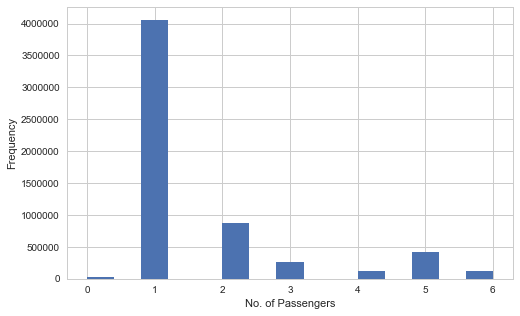

In [393]:
plt.figure(figsize=(8,5))
plt.hist(train['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Here __Passenger_count = 0__, means drop and pickup location are same.
It may be taxi transporting some goods without passengers or may be an error or passenger didn't take the cab after the cab arrived and a cancellation fee was charged.

Text(0,0.5,'Fare')

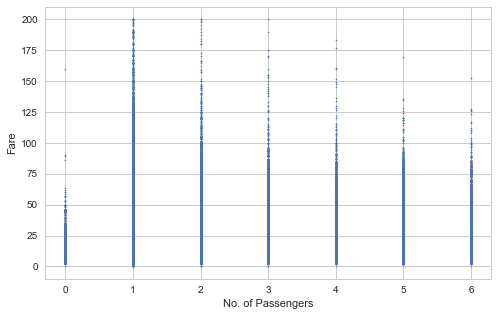

In [394]:
plt.figure(figsize=(8,5))
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

we can see that single passengers are the most frequent travellers, and the highest fare also seems to come from cabs which carry just 1 passenger.

***

__Does the distance affect the fare?__

- ### Added distance column

In [395]:
# Distance in KM
def cal_distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a)) 

In [396]:
def Distance(df):

    JFK_coord = (40.6413, -73.7781)
    EWR_coord = (40.6895, -74.1745)
    LGA_coord = (40.7769, -73.8740)
    
    pickup_lat = df['pickup_latitude']
    dropoff_lat = df['dropoff_latitude']
    pickup_lon = df['pickup_longitude']
    dropoff_lon = df['dropoff_longitude']
    
    # calculates distance between (pickup location and airports) OR (airports and dropoff location)
    df['pickup_jfk'] = cal_distance(pickup_lat, pickup_lon, JFK_coord[0], JFK_coord[1]) 
    df['dropoff_jfk'] = cal_distance(JFK_coord[0], JFK_coord[1], dropoff_lat, dropoff_lon) 
    df['pickup_ewr'] = cal_distance(pickup_lat, pickup_lon, EWR_coord[0], EWR_coord[1])
    df['dropoff_ewr'] = cal_distance(EWR_coord[0], EWR_coord[1], dropoff_lat, dropoff_lon) 
    df['pickup_lga'] = cal_distance(pickup_lat, pickup_lon, LGA_coord[0], LGA_coord[1]) 
    df['dropoff_lga'] = cal_distance(LGA_coord[0], LGA_coord[1], dropoff_lat, dropoff_lon)
    
    # calculates distance between pickup location and dropoff location
    df['distance_km'] = cal_distance(df.pickup_latitude, df.pickup_longitude,df.dropoff_latitude, df.dropoff_longitude)
    return df

In [397]:
train = Distance(train)

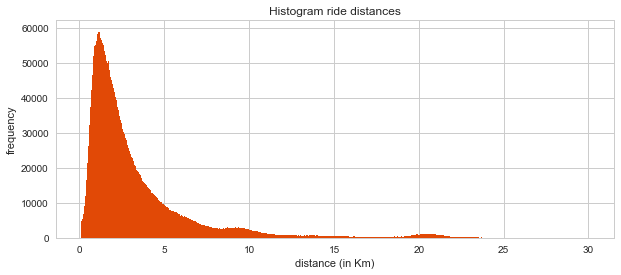

In [398]:
train[(train.distance_km > 0.1) & (train.distance_km < 30)].distance_km.hist(bins=1000, figsize=(10,4), color='#E14906')
plt.xlabel('distance (in Km)')
plt.ylabel('frequency')
plt.title('Histogram ride distances')
plt.savefig('distance')

In [399]:
train.distance_km.describe()

count    5.865197e+06
mean     3.314762e+00
std      3.735415e+00
min      0.000000e+00
25%      1.253208e+00
50%      2.150412e+00
75%      3.902482e+00
max      1.438347e+02
Name: distance_km, dtype: float64

In [400]:
Counter(train['distance_km'] == 0)

Counter({False: 5803391, True: 61806})

Here __distance_km = 0__ 
- pickup and dropoff location are same. 
- The cab waited the whole time and the passenger eventually cancelled. That's why the pickup and drop co-ordinates are the same and maybe, the passenger was charged for the waiting time.

In [401]:
Counter(train['distance_km'] > 200)

Counter({False: 5865197})

Generally, People don't travel more than 200 Km by taxi  in NYC because of metro.

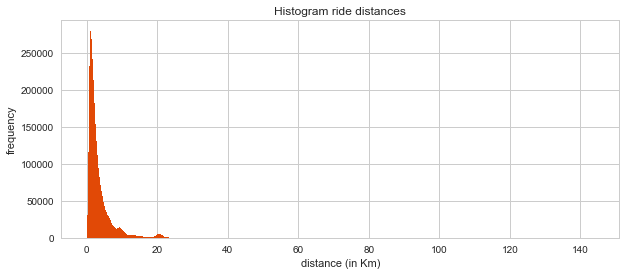

In [402]:
train.distance_km.hist(bins=1000, figsize=(10,4), color='#E14906')
plt.xlabel('distance (in Km)')
plt.ylabel('frequency')
plt.title('Histogram ride distances')
plt.savefig('distance')

As we can see from the above, the abnormally high distances are due to either the pickup or dropoff co-ordinates being incorrect or 0.<br> distance = (fare_amount - 2.5)/1.56

In [ ]:
train['distance'] = train.apply(lambda row: (row['fare_amount'] - 2.50)/1.56, axis=1)

https://www.taxi-calculator.com/taxi-fare-new-york-city/259 <br>
A quick Google search gave me the following prices <br>
 -  2.5 base-price + 1.56/km --> 6AM to 8PM Mon-Fri
 -  3.0 base-price + 1.56/km --> 8PM to 6AM Mon-Fri and Sat&Sun <br>
 all money are in $

I'm removing any fares less than $2.50. This appears to be the minimum fare, so any values in the training set less than this amount must be errors in data collection or entry.

In [ ]:
train = train[train['fare_amount'].between(left = 2.5, right = 100)]

In [ ]:
# Bin the fare and convert to string
train['fare-bin'] = pd.cut(train['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
train.loc[train['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
train.loc[train['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
train['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k',figsize=(8,5));
plt.title('Fare Binned');

In [ ]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(18,4))
axs[0].scatter(train.distance_km, train.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance(in unit)')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('scatter plot btw distance & fare')


idx = ((train.distance_km > 0) & (train.distance_km < 25)) & ((train.fare_amount > 0) & (train.fare_amount < 100))
axs[1].scatter(train[idx].distance_km, train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance(in Km)')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 25 Km , fare < $100');

In [ ]:
train.groupby('fare-bin')['distance_km'].mean().plot.bar(color = 'b',figsize=(8,5));
plt.title('Average Distance by Fare Bin');

***

__ Does the date and time of pickup affect the fare?__

- ###  Added year, month, day, hour, dayOfWeek

In [ ]:
# splits datetime into categorical data
def add_datetime(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
    df['year'] = df.pickup_datetime.dt.year
    df['month'] = df.pickup_datetime.dt.month
    df['day'] = df.pickup_datetime.dt.day
    df['hour'] = df.pickup_datetime.dt.hour
    df['dayOfWeek'] = df.pickup_datetime.dt.dayofweek
    df['week'] = df.pickup_datetime.apply(lambda x:calendar.day_name[x.weekday()])
    return df

In [ ]:
train = add_datetime(train)

In [ ]:
train['dayOfWeek'].value_counts()

In [ ]:
train['week'].value_counts()

In [ ]:
trips_year = train.groupby(['year'])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
trips_year.head()
sns.barplot(x='year',y='Num_Trips',data=trips_year)

The reason for this graph could the non-availability of whole data of year 2015.

In [ ]:
train.groupby(['year'])['month'].value_counts()

***

In [ ]:
trips_year_fareamount = train.groupby(['year'])['fare_amount'].mean().reset_index().rename(
    columns={'fare_amount':'avg_fare_amt_yearly'})
trips_year_fareamount

In [ ]:
trips_year_dist = train.groupby(['year'])['distance_km'].mean().reset_index().rename(columns={'distance_km':'avg_distance_yearly'})
trips_year_dist

In [ ]:
df = pd.merge(trips_year_fareamount,trips_year_dist, on = 'year')
df

In [ ]:
df['avg_fare_per_dist'] = df.apply(lambda row: row.avg_fare_amt_yearly / row.avg_distance_yearly, axis=1)
df

In [ ]:
df = df.drop(['avg_fare_amt_yearly','avg_distance_yearly'], axis = 1)
df

In [ ]:
sns.barplot(x='year',y='avg_fare_per_dist',data=df).set_title("Avg Fare Amount over Years per Km")

Avg Fare per Km has beern increasing over the years.

In [ ]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(15,5))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

In [ ]:
groupandplot(train,'month','fare_amount')

In [ ]:
groupandplot(train,'week','fare_amount')

In [ ]:
groupandplot(train,'hour','fare_amount')

In [ ]:
groupandplot(train,'passenger_count','fare_amount')

***

In [ ]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007
    },
    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395
    },
    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176
    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490
    } 
}

In [ ]:
def Borough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'


In [427]:
train['pickup_borough']=train.apply(lambda row:Borough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['dropoff_borough']=train.apply(lambda row:Borough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [428]:
train['pickup_borough'].value_counts()

manhattan        5591717
queens            237487
brooklyn           25264
others              6075
bronx               2833
staten_island        159
Name: pickup_borough, dtype: int64

In [429]:
train['dropoff_borough'].value_counts()

manhattan        5525857
queens            231610
brooklyn           70846
bronx              19199
others             15208
staten_island        815
Name: dropoff_borough, dtype: int64

In [430]:
train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_jfk,dropoff_jfk,...,distance,fare-bin,year,month,day,hour,dayOfWeek,week,pickup_borough,dropoff_borough
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,10.504346,9.538054,...,1.282051,"(0.0, 5.0]",2009,6,15,17,0,Monday,queens,queens
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,21.523172,23.071126,...,9.230769,"(15.0, 20.0]",2010,1,5,16,1,Tuesday,manhattan,manhattan


Text(0.5,1,'Distribution of Pickup Boroughs')

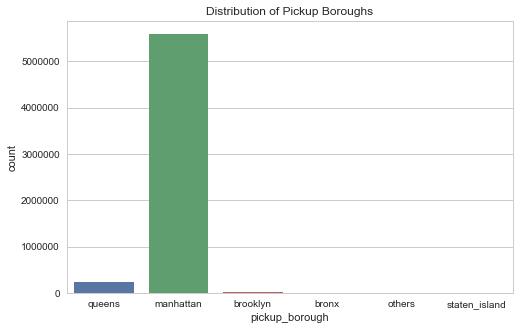

In [431]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

Text(0.5,1,'Distribution of Dropoff Boroughs')

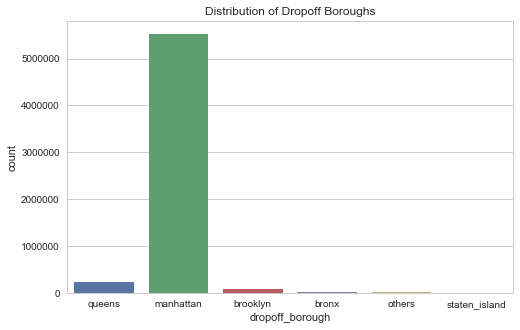

In [432]:
plt.figure(figsize=(8,5))
sns.countplot(train['dropoff_borough'])
plt.title("Distribution of Dropoff Boroughs")

C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


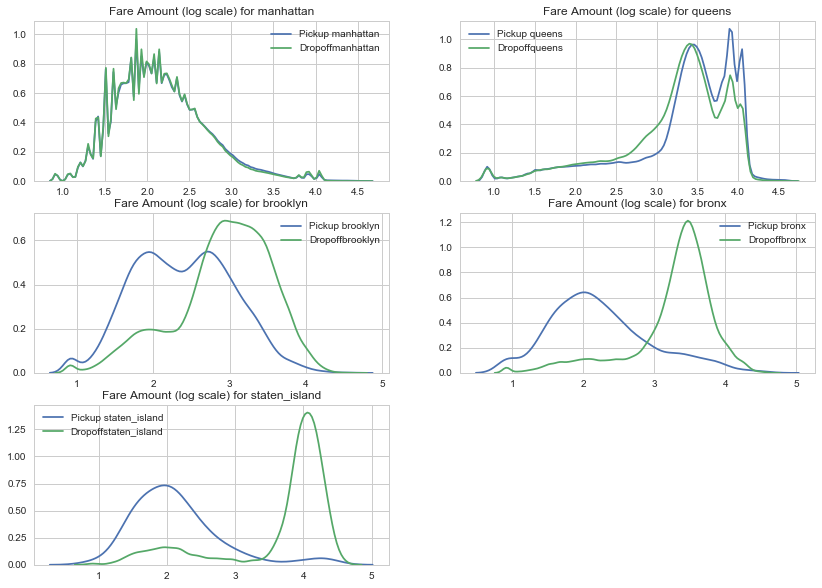

In [433]:
plt.figure(figsize=(14,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    
    i=i+1

As from the above graph, we observed there is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan. We can see pickups from Queens is expensive compared to pickups from other Buroughs.Very high difference in pickup and dropoff prices for Staten Island.

C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


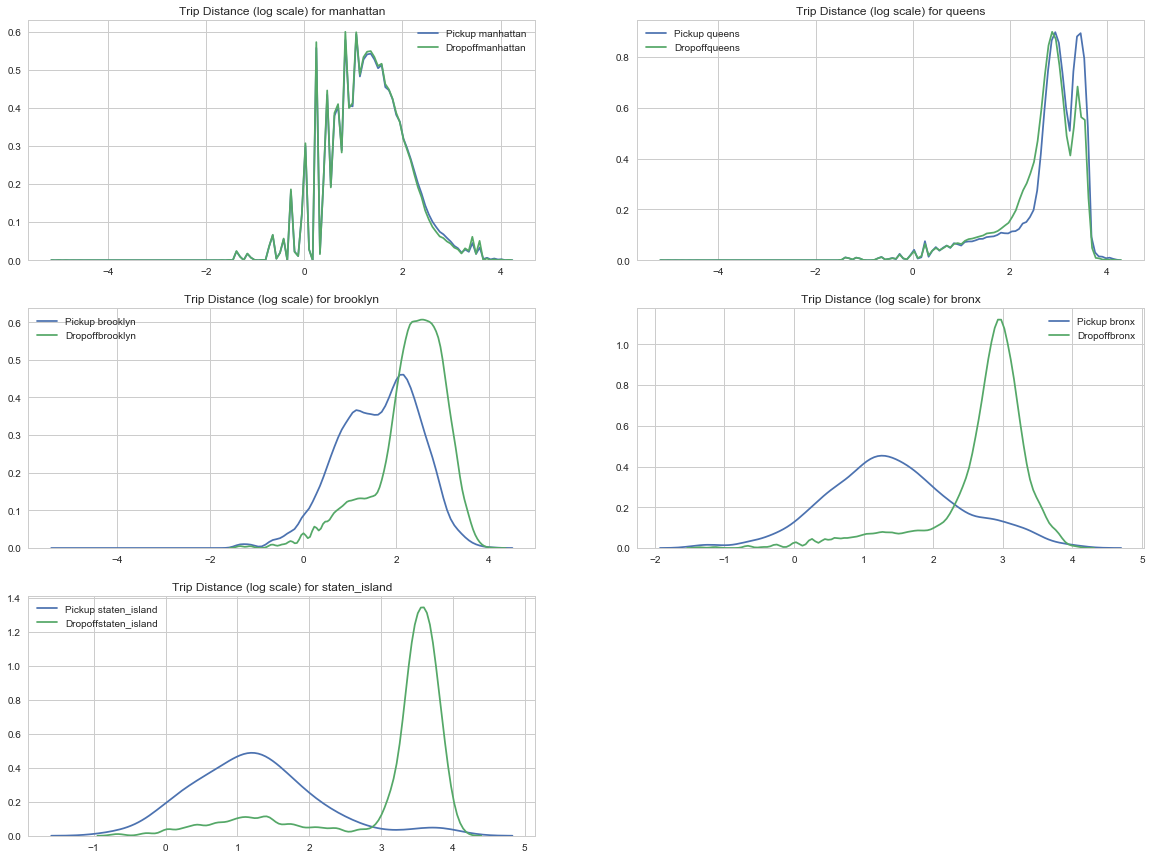

In [434]:
plt.figure(figsize=(20,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log scale) for "+key)
    i=i+1

Dropoffs to Bronx and Staten island are long trips. In Manhattan the pickup and dropoffs fare amount has similar distribution. Let us add a field, is_lower_manhattan as we had seen above that dropoffs to lower manhattan had higher trip distance but lower fare

In [435]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [436]:
train['is_pickup_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['is_dropoff_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

__How does Fare Amount differ for pickups and dropoff for Lower Manhattan compared to rest of Manhattan__

In [437]:
manhattan=train.loc[(train['pickup_borough']=='manhattan') | (train['dropoff_borough']=='manhattan')]

C:\Users\Pankaj_temp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

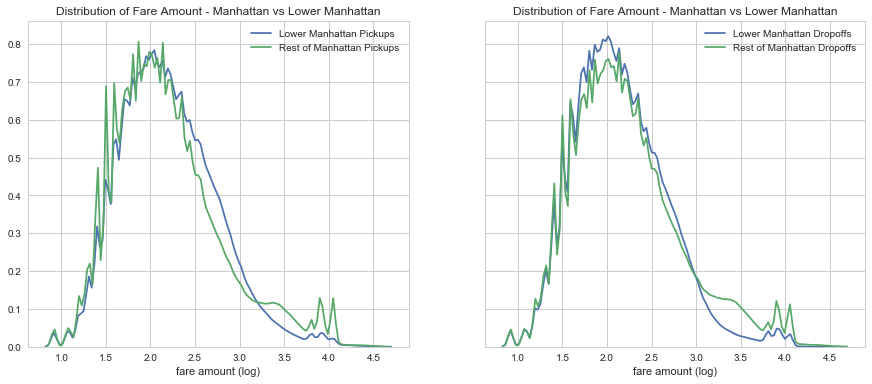

In [438]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharex=True, sharey=True)
axes = axes.flatten()

sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Pickups',ax = axes[0])
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Pickups',ax = axes[0])
axes[0].set_xlabel("fare amount (log)")
axes[0].set_title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Dropoffs',ax = axes[1])
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Dropoffs',ax = axes[1])
axes[1].set_xlabel("fare amount (log)")
axes[1].set_title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

***

In [439]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_jfk', 'dropoff_jfk', 'pickup_ewr',
       'dropoff_ewr', 'pickup_lga', 'dropoff_lga', 'distance_km', 'distance',
       'fare-bin', 'year', 'month', 'day', 'hour', 'dayOfWeek', 'week',
       'pickup_borough', 'dropoff_borough', 'is_pickup_lower_manhattan',
       'is_dropoff_lower_manhattan'],
      dtype='object')

__Data Correlation__

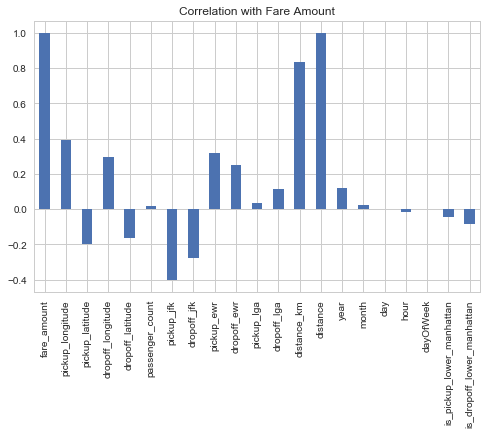

In [440]:
corrs = train.corr()
corrs['fare_amount'].plot.bar(color = 'b', figsize=(8,5));
plt.title('Correlation with Fare Amount');

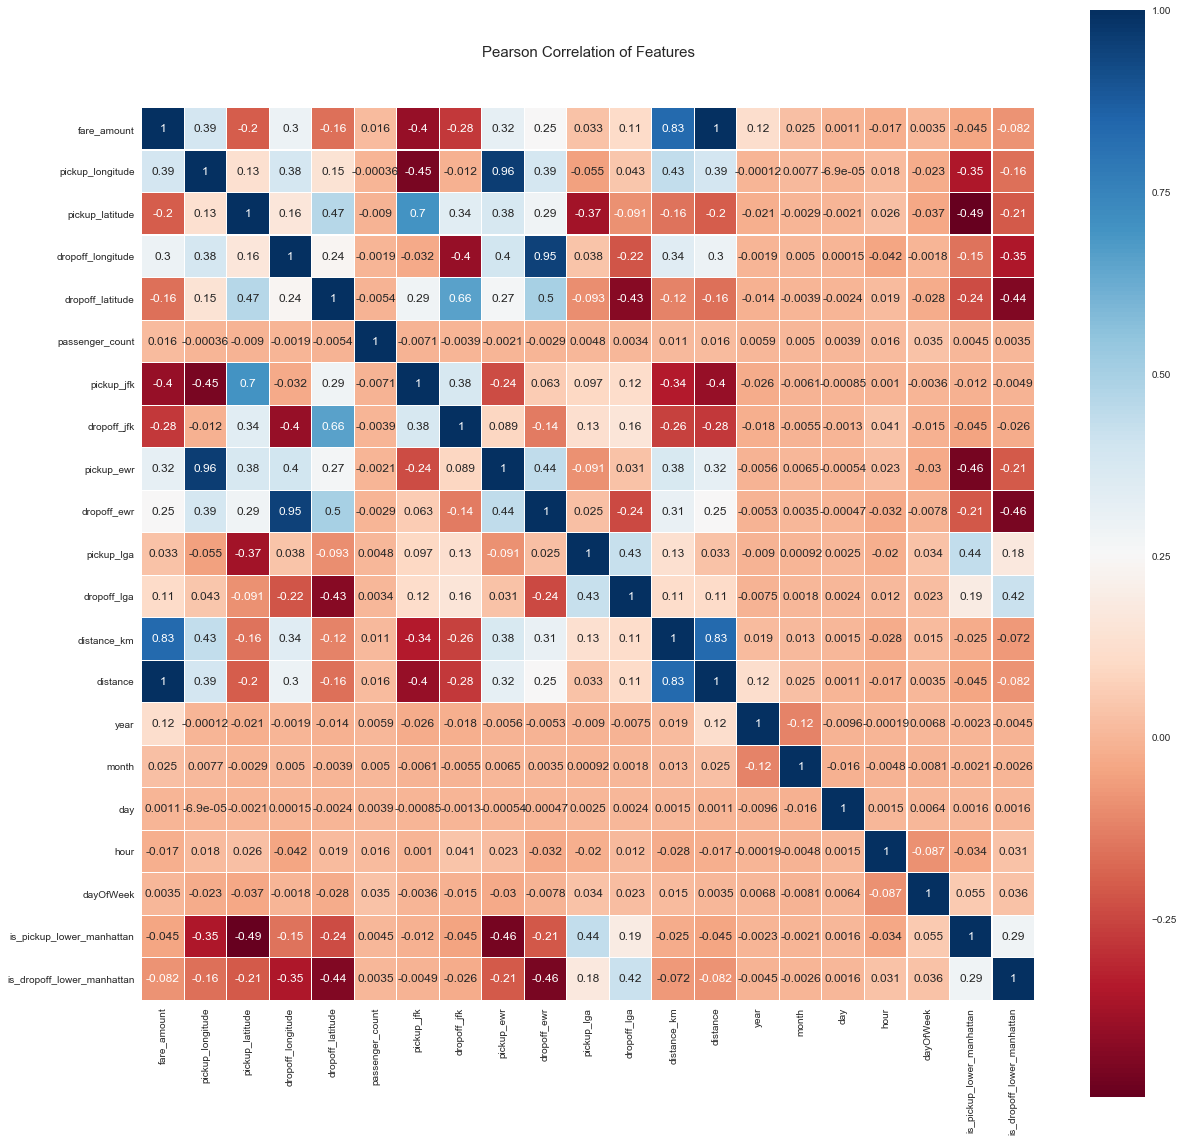

In [441]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

***

In [442]:
rate = train.fare_amount.mean()/train.distance_km.mean() 
print("Rate: ${:.2f}/km".format(rate))

Rate: $3.40/km


***

In [76]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
from sklearn.tree import DecisionTreeRegressor  
regressor = DecisionTreeRegressor()  
regressor.fit(X_train, y_train) 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [78]:
y_pred = regressor.predict(X_test)  

In [80]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})  

In [81]:
df.head(10)

,Actual,Predicted
110187,3.3,3.3
112519,5.0,6.0
168446,3.3,4.5
102488,14.5,7.0
37402,10.9,13.5
189084,7.5,10.1
18288,17.9,17.3
6754,22.5,23.7
165721,9.0,9.7
51977,6.1,8.1


In [82]:
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 3.4148138900359153
Mean Squared Error: 47.48412573509113
Root Mean Squared Error: 6.890872639592981


***

In [87]:
#splitting data into train and test
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 10)  

In [88]:
# Training the Algorithm
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train)  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [89]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df 

,Coefficient
passenger_count,0.041931
distance,2.003913
dayOfWeek,-0.050871
month,0.036557


In [90]:
y_pred = regressor.predict(X_test).astype(int)

In [91]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  
df.head()

,Actual,Predicted
159228,6.1,8
85411,16.0,15
5753,5.0,6
165121,5.0,5
175718,11.7,11


In [92]:
#Evaluating the Algorithm
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 2.5009613975287603
Mean Squared Error: 30.6529811146144
Root Mean Squared Error: 5.536513443911646
